In [1]:
import pandas as pd
import numpy as dragon
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
import re

#importing packages for the prediction of time-series data
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error

In [2]:
train = pd.read_csv(r'C:\Users\Sahil\Desktop\IITP\VScode\Bitcoin\BTCUSD_day.csv')
train.head()

Date  Symbol     Open     High      Low    Close  Volume BTC  \
0  2020-04-10  BTCUSD  7315.25  7315.25  7315.25  7315.25        0.00   
1  2020-04-09  BTCUSD  7369.60  7378.85  7115.04  7315.25     2237.13   
2  2020-04-08  BTCUSD  7201.81  7432.23  7152.80  7369.60     2483.60   
3  2020-04-07  BTCUSD  7336.96  7468.42  7078.00  7201.81     2333.34   
4  2020-04-06  BTCUSD  6775.21  7369.76  6771.01  7336.96     3727.47   

    Volume USD  
0         0.00  
1  16310014.53  
2  18138080.27  
3  17047120.32  
4  26533750.17

In [3]:
train['Date'] = pd.to_datetime(train['Date'])

In [5]:
train.drop(train[train['Volume BTC'] == 0].index, inplace = True)
train.drop(['Symbol'],axis = 1, inplace = True)

<class 'pandas.core.frame.DataFrame'>
             Close
Date              
2015-10-08  243.95
2015-10-09  245.39
2015-10-10  246.30
2015-10-11  249.50
2015-10-12  247.60


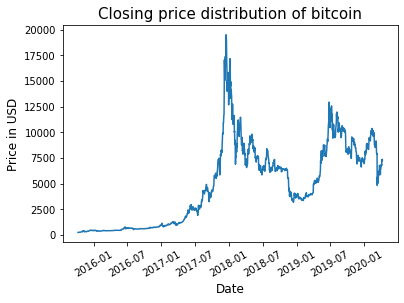

In [6]:
data = train['Close']
Date1 = train['Date']
train1 = train[['Date','Close']]
# Setting the Date as Index
train2 = train1.set_index('Date')
train2.sort_index(inplace=True)
print (type(train2))
print (train2.head())
#plot.figure(figsize = (15,10))
plot.plot(train2)
plot.xlabel('Date', fontsize=12)
plot.ylabel('Price in USD', fontsize=12)
plot.title("Closing price distribution of bitcoin", fontsize=15)
plot.xticks(rotation = 30)
plot.show()

Testing the Stationarity

Augmented Dicky Fuller Test:

The Augmented Dicky Fuller test is a type of statistical test called a unit root test.

The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend.

There are no. of unit root tests and ADF is one of the most widely used

1. Null Hypothesis (H0): Null hypothesis of the test is that the time series can be represented by a unit root that is not stationary.

2. Alternative Hypothesis (H1): Alternative Hypothesis of the test is that the time series is stationary.

Interpretation of p value

1. p value > 0.05: Accepts the Null Hypothesis (H0), the data has a unit root and is non-stationary.

2. p value < = 0.05: Rejects the Null Hypothesis (H0), the data is stationary.

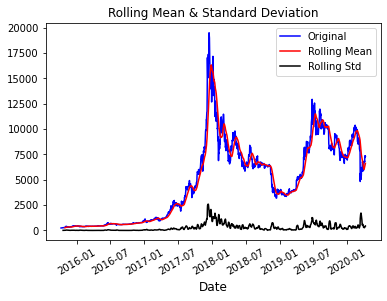

ADF Stastistic: -2.011440
p-value: 0.281580
The graph is non stationery
Critical values:
	1%: -3.434 
	5%: -2.863 
	10%: -2.568 


In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='blue',label='Original')
    mean = plot.plot(rolmean, color='red', label='Rolling Mean')
    std = plot.plot(rolstd, color='black', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.xticks(rotation = 30)
    plot.xlabel('Date', fontsize=12)
    plot.title('Rolling Mean & Standard Deviation')
    plot.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x, autolag='AIC')
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))
        
ts = train2['Close']      
test_stationarity(ts)

Since the p value is greater than 0.05 the time series is non stationary. Okay so far we tested the series and it is non stationary. So there is some work that needs to be done here. So now we use transformations to make the series stationary.

Log Transforming the series

Log transformation is used to unskew highly skewed data. Thus helping in forecasting process.

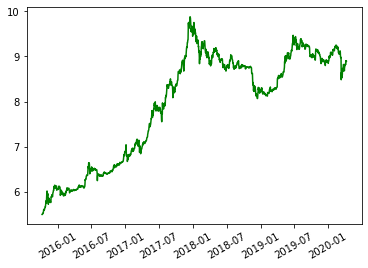

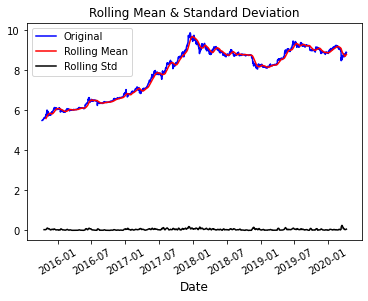

ADF Stastistic: -1.907645
p-value: 0.328473
The graph is non stationery
Critical values:
	1%: -3.434 
	5%: -2.863 
	10%: -2.568 


In [8]:
ts_log = dragon.log(ts)
plot.plot(ts_log,color="green")
plot.xticks(rotation = 30)
plot.show()

test_stationarity(ts_log)

In [9]:
from scipy.stats import zscore

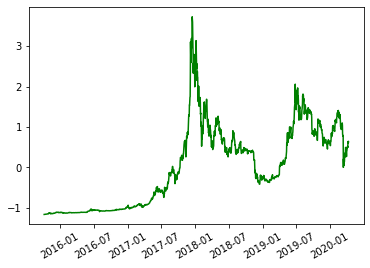

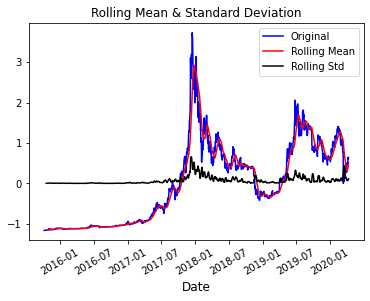

ADF Stastistic: -2.011440
p-value: 0.281580
The graph is non stationery
Critical values:
	1%: -3.434 
	5%: -2.863 
	10%: -2.568 


In [10]:
ts_z = zscore(ts)
plot.plot(ts_z,color="green")
plot.xticks(rotation = 30)
plot.show()

test_stationarity(ts_z)

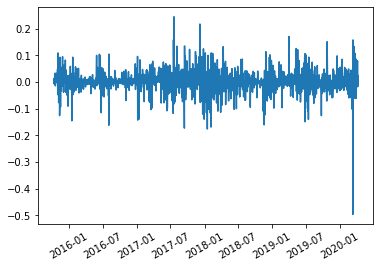

In [11]:
ts_log_diff = ts_log - ts_log.shift()
plot.plot(ts_log_diff)
plot.xticks(rotation = 30)
plot.show()

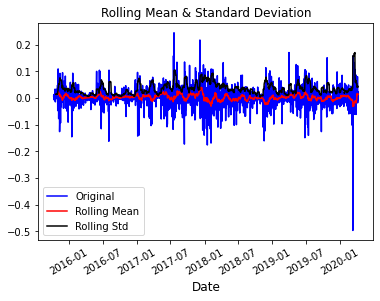

ADF Stastistic: -28.291281
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.434 
	5%: -2.863 
	10%: -2.568 


In [13]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

As our time series is now stationary asour p value is less than 0.05 therefore we can apply time series forecasting models.

Auto Regressive model

Auto regressive model is a time series forecasting model where current values are dependent on past values.

In [15]:
from statsmodels.tsa.arima_model import ARIMA

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


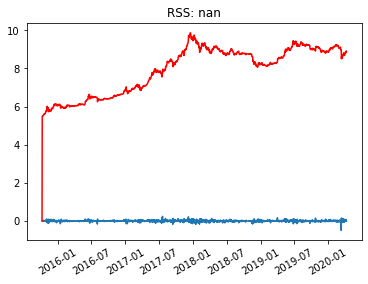

In [17]:
# follow lag
model = sm.tsa.arima.ARIMA(ts_log, order=(1,1,0))  
#results_ARIMA = model.fit(disp=-1)  
results_ARIMA = model.fit() 
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plot.xticks(rotation=30)
plot.show()

In [26]:
len(ts_log)

1643

Printing Predicted vs Expected Values...


predicted = 3733.741655,   expected = 3771.430000,   error = 0.999312  %
predicted = 3767.037645,   expected = 4223.690000,   error = 10.811692  %
predicted = 4223.906052,   expected = 4240.530000,   error = 0.392025  %
predicted = 4249.371047,   expected = 3984.010000,   error = 6.660652  %
predicted = 3984.548098,   expected = 4141.590000,   error = 3.791826  %
predicted = 4137.390139,   expected = 4101.250000,   error = 0.881198  %
predicted = 4103.743881,   expected = 3835.010000,   error = 7.007384  %
predicted = 3835.093882,   expected = 3903.940000,   error = 1.763503  %
predicted = 3900.186941,   expected = 3691.920000,   error = 5.641155  %
predicted = 3693.643838,   expected = 3436.540000,   error = 7.481474  %
predicted = 3434.036285,   expected = 3377.830000,   error = 1.663976  %
predicted = 3374.178183,   expected = 3394.500000,   error = 0.598669  %
predicted = 3393.606428,   expected = 3529.660000,   error = 3.854580  %
predict

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 3354.440772,   expected = 3431.890000,   error = 2.256751  %
predicted = 3431.009449,   expected = 3265.440000,   error = 5.070356  %
predicted = 3266.783765,   expected = 3195.430000,   error = 2.232994  %
predicted = 3193.289511,   expected = 3184.060000,   error = 0.289866  %
predicted = 3183.100498,   expected = 3193.000000,   error = 0.310038  %
predicted = 3192.828490,   expected = 3502.840000,   error = 8.850290  %
predicted = 3502.610882,   expected = 3667.820000,   error = 4.504286  %
predicted = 3672.748435,   expected = 3683.970000,   error = 0.304605  %
predicted = 3686.383262,   expected = 4077.290000,   error = 9.587416  %
predicted = 4078.140667,   expected = 3839.060000,   error = 6.227583  %
predicted = 3845.841464,   expected = 3979.350000,   error = 3.355034  %
predicted = 3974.615949,   expected = 3948.580000,   error = 0.659375  %
predicted = 3951.264293,   expected = 4036.000000,   error = 2.099497  %
predicted = 4035.149630,   expected = 3777.970000, 

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 3893.111792,   expected = 3786.910000,   error = 2.804445  %
predicted = 3789.457492,   expected = 3821.470000,   error = 0.837701  %
predicted = 3818.674444,   expected = 3797.410000,   error = 0.559972  %
predicted = 3798.470203,   expected = 4041.010000,   error = 6.001960  %
predicted = 4037.881848,   expected = 4007.470000,   error = 0.758879  %
predicted = 4013.849480,   expected = 3992.240000,   error = 0.541287  %
predicted = 3991.595246,   expected = 4000.670000,   error = 0.226831  %
predicted = 4000.217693,   expected = 3626.760000,   error = 10.297282  %
predicted = 3630.618842,   expected = 3637.280000,   error = 0.183136  %
predicted = 3628.536565,   expected = 3618.820000,   error = 0.268501  %
predicted = 3619.266933,   expected = 3514.080000,   error = 2.993299  %
predicted = 3514.712045,   expected = 3662.890000,   error = 4.045384  %
predicted = 3658.627484,   expected = 3583.470000,   error = 2.097338  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 3588.006157,   expected = 3604.570000,   error = 0.459523  %
predicted = 3602.386126,   expected = 3641.400000,   error = 1.071398  %
predicted = 3641.501938,   expected = 3608.000000,   error = 0.928546  %
predicted = 3609.276809,   expected = 3687.000000,   error = 2.108033  %
predicted = 3685.245987,   expected = 3533.490000,   error = 4.294790  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 3537.184506,   expected = 3532.250000,   error = 0.139699  %
predicted = 3528.552606,   expected = 3577.240000,   error = 1.361032  %
predicted = 3576.668347,   expected = 3553.020000,   error = 0.665584  %
predicted = 3554.408622,   expected = 3570.250000,   error = 0.443705  %
predicted = 3569.449337,   expected = 3561.000000,   error = 0.237274  %
predicted = 3561.532593,   expected = 3558.190000,   error = 0.093941  %
predicted = 3557.997859,   expected = 3529.630000,   error = 0.803706  %
predicted = 3529.903333,   expected = 3429.700000,   error = 2.921636  %
predicted = 3430.194399,   expected = 3395.490000,   error = 1.022073  %
predicted = 3393.497699,   expected = 3436.110000,   error = 1.240132  %
predicted = 3434.788614,   expected = 3412.100000,   error = 0.664946  %
predicted = 3413.373413,   expected = 3441.870000,   error = 0.827939  %
predicted = 3440.925173,   expected = 3469.060000,   error = 0.811022  %
predicted = 3469.472388,   expected = 3415.990000, 

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 3646.969365,   expected = 3588.580000,   error = 1.627088  %
predicted = 3589.820264,   expected = 3588.610000,   error = 0.033725  %
predicted = 3587.227753,   expected = 3576.480000,   error = 0.300512  %
predicted = 3576.626047,   expected = 3562.290000,   error = 0.402439  %
predicted = 3562.172929,   expected = 3567.120000,   error = 0.138685  %
predicted = 3566.724700,   expected = 3582.300000,   error = 0.434785  %
predicted = 3582.232953,   expected = 3626.700000,   error = 1.226102  %
predicted = 3626.531658,   expected = 3866.990000,   error = 6.218230  %
predicted = 3865.258067,   expected = 3892.030000,   error = 0.687866  %
predicted = 3897.734210,   expected = 3941.160000,   error = 1.101853  %
predicted = 3941.219081,   expected = 3901.590000,   error = 1.015716  %
predicted = 3903.227231,   expected = 3946.560000,   error = 1.097988  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 3945.073055,   expected = 4110.990000,   error = 4.035936  %
predicted = 4110.247545,   expected = 3732.480000,   error = 10.121087  %
predicted = 3740.823290,   expected = 3820.260000,   error = 2.079354  %
predicted = 3810.163047,   expected = 3799.990000,   error = 0.267712  %
predicted = 3802.407984,   expected = 3800.000000,   error = 0.063368  %
predicted = 3799.512357,   expected = 3791.490000,   error = 0.211589  %
predicted = 3791.610630,   expected = 3808.120000,   error = 0.433531  %
predicted = 3807.677965,   expected = 3812.450000,   error = 0.125170  %
predicted = 3812.791100,   expected = 3789.610000,   error = 0.611701  %
predicted = 3790.036471,   expected = 3700.820000,   error = 2.410722  %
predicted = 3701.521261,   expected = 3845.730000,   error = 3.749840  %
predicted = 3841.398183,   expected = 3850.460000,   error = 0.235344  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 3853.934858,   expected = 3855.260000,   error = 0.034372  %
predicted = 3855.303883,   expected = 3842.000000,   error = 0.346275  %
predicted = 3842.306621,   expected = 3917.490000,   error = 1.919172  %
predicted = 3916.058940,   expected = 3899.070000,   error = 0.435718  %
predicted = 3901.157089,   expected = 3851.150000,   error = 1.298498  %
predicted = 3851.409919,   expected = 3862.120000,   error = 0.277311  %
predicted = 3860.821495,   expected = 3850.960000,   error = 0.256079  %
predicted = 3851.383698,   expected = 3855.870000,   error = 0.116350  %
predicted = 3855.532207,   expected = 3901.000000,   error = 1.165542  %
predicted = 3900.457546,   expected = 3990.000000,   error = 2.244172  %
predicted = 3989.808721,   expected = 3965.450000,   error = 0.614274  %
predicted = 3967.936775,   expected = 3969.990000,   error = 0.051719  %
predicted = 3969.340305,   expected = 4001.300000,   error = 0.798733  %
predicted = 4000.953289,   expected = 4032.000000, 

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 5173.766146,   expected = 5157.020000,   error = 0.324725  %
predicted = 5158.023388,   expected = 5149.860000,   error = 0.158517  %
predicted = 5149.566470,   expected = 5266.340000,   error = 2.217356  %
predicted = 5264.577681,   expected = 5329.970000,   error = 1.226880  %
predicted = 5331.826622,   expected = 5391.010000,   error = 1.097816  %
predicted = 5391.672746,   expected = 5660.300000,   error = 4.745813  %
predicted = 5658.184476,   expected = 5769.510000,   error = 1.929549  %
predicted = 5774.669822,   expected = 5715.300000,   error = 1.038788  %
predicted = 5718.504891,   expected = 5686.650000,   error = 0.560170  %
predicted = 5685.778438,   expected = 5745.000000,   error = 1.030837  %
predicted = 5743.591141,   expected = 5935.100000,   error = 3.226717  %
predicted = 5934.057716,   expected = 6146.180000,   error = 3.451287  %
predicted = 6148.210880,   expected = 6378.010000,   error = 3.602991  %
predicted = 6380.584973,   expected = 7227.750000, 

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8022.081786,   expected = 8198.470000,   error = 2.151477  %
predicted = 8201.914174,   expected = 7881.380000,   error = 4.066980  %
predicted = 7891.433230,   expected = 7361.920000,   error = 7.192597  %
predicted = 7358.231116,   expected = 7262.520000,   error = 1.317877  %
predicted = 7247.976654,   expected = 8192.440000,   error = 11.528474  %
predicted = 8178.429239,   expected = 8003.970000,   error = 2.179659  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8032.982658,   expected = 7954.490000,   error = 0.986772  %
predicted = 7950.075494,   expected = 7620.000000,   error = 4.331699  %
predicted = 7622.652381,   expected = 7879.920000,   error = 3.264851  %
predicted = 7867.265912,   expected = 8004.360000,   error = 1.712743  %
predicted = 8010.077920,   expected = 8074.870000,   error = 0.802392  %
predicted = 8077.438102,   expected = 8750.010000,   error = 7.686527  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8743.656641,   expected = 8781.160000,   error = 0.427089  %
predicted = 8800.447086,   expected = 8726.400000,   error = 0.848541  %
predicted = 8727.906086,   expected = 8659.180000,   error = 0.793679  %
predicted = 8658.487349,   expected = 8273.760000,   error = 4.649970  %
predicted = 8276.419922,   expected = 8516.200000,   error = 2.815576  %
predicted = 8502.489239,   expected = 8566.100000,   error = 0.742587  %
predicted = 8572.265448,   expected = 8745.750000,   error = 1.983644  %
predicted = 8744.947980,   expected = 8110.990000,   error = 7.816037  %
predicted = 8123.522064,   expected = 7682.810000,   error = 5.736339  %
predicted = 7671.806197,   expected = 7791.420000,   error = 1.535199  %
predicted = 7779.029357,   expected = 7801.000000,   error = 0.281639  %
predicted = 7803.774523,   expected = 8002.980000,   error = 2.489141  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8000.917322,   expected = 7936.350000,   error = 0.813564  %
predicted = 7942.485200,   expected = 7643.460000,   error = 3.912171  %
predicted = 7645.047327,   expected = 8024.350000,   error = 4.726896  %
predicted = 8011.821868,   expected = 7920.630000,   error = 1.151321  %
predicted = 7931.943916,   expected = 8176.440000,   error = 2.990251  %
predicted = 8170.332574,   expected = 8256.090000,   error = 1.038717  %
predicted = 8262.091254,   expected = 8699.710000,   error = 5.030268  %
predicted = 8696.473576,   expected = 8853.300000,   error = 1.771389  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8864.223434,   expected = 8989.890000,   error = 1.397865  %
predicted = 8992.666874,   expected = 9331.030000,   error = 3.626214  %
predicted = 9331.095115,   expected = 9084.310000,   error = 2.716608  %
predicted = 9096.651058,   expected = 9282.650000,   error = 2.003727  %
predicted = 9273.199196,   expected = 9534.880000,   error = 2.744458  %
predicted = 9537.615655,   expected = 10233.920000,   error = 6.803887  %
predicted = 10233.861942,   expected = 10676.480000,   error = 4.145730  %
predicted = 10694.215964,   expected = 10842.820000,   error = 1.370529  %
predicted = 10854.870605,   expected = 11035.000000,   error = 1.632346  %
predicted = 11038.331725,   expected = 11759.900000,   error = 6.135837  %
predicted = 11759.701708,   expected = 12936.450000,   error = 9.096377  %
predicted = 12954.867733,   expected = 11143.740000,   error = 16.252423  %
predicted = 11192.971192,   expected = 12388.240000,   error = 9.648415  %
predicted = 12305.925427,   expecte

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 10980.845741,   expected = 11242.220000,   error = 2.324935  %
predicted = 11233.930354,   expected = 11475.070000,   error = 2.101422  %
predicted = 11476.417771,   expected = 12307.130000,   error = 6.749845  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 12297.187259,   expected = 12570.420000,   error = 2.173617  %
predicted = 12586.875465,   expected = 12097.340000,   error = 4.046637  %
predicted = 12111.671160,   expected = 11320.130000,   error = 6.992333  %
predicted = 11323.337629,   expected = 11776.400000,   error = 3.847206  %
predicted = 11751.054446,   expected = 11374.760000,   error = 3.308153  %
predicted = 11392.319596,   expected = 10200.800000,   error = 11.680649  %
predicted = 10212.594477,   expected = 10850.000000,   error = 5.874705  %
predicted = 10813.394571,   expected = 9429.050000,   error = 14.681697  %
predicted = 9475.593840,   expected = 9703.580000,   error = 2.349506  %
predicted = 9660.351826,   expected = 10647.850000,   error = 9.274156  %
predicted = 10630.511770,   expected = 10535.460000,   error = 0.902208  %
predicted = 10558.463286,   expected = 10753.170000,   error = 1.810691  %
predicted = 10745.358273,   expected = 10590.000000,   error = 1.467028  %
predicted = 10598.632709,  

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 10023.146199,   expected = 10297.860000,   error = 2.667679  %
predicted = 10271.415281,   expected = 10360.220000,   error = 0.857170  %
predicted = 10365.577582,   expected = 10198.840000,   error = 1.634868  %
predicted = 10203.973367,   expected = 10317.970000,   error = 1.104836  %
predicted = 10311.393547,   expected = 10919.990000,   error = 5.573233  %
predicted = 10908.806726,   expected = 10747.060000,   error = 1.505032  %
predicted = 10765.115494,   expected = 10132.440000,   error = 6.244059  %
predicted = 10142.548915,   expected = 10164.820000,   error = 0.219100  %
predicted = 10151.147385,   expected = 10408.140000,   error = 2.469150  %
predicted = 10403.216755,   expected = 10151.830000,   error = 2.476270  %
predicted = 10162.710471,   expected = 10135.590000,   error = 0.267577  %
predicted = 10130.675317,   expected = 10367.230000,   error = 2.281754  %
predicted = 10361.483213,   expected = 10175.800000,   error = 1.824753  %
predicted = 10184.971391,

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8293.035958,   expected = 8330.620000,   error = 0.451155  %
predicted = 8335.671044,   expected = 8384.510000,   error = 0.582490  %
predicted = 8384.124133,   expected = 8206.450000,   error = 2.165055  %
predicted = 8211.038595,   expected = 8157.300000,   error = 0.658779  %
predicted = 8154.314727,   expected = 8150.970000,   error = 0.041035  %
predicted = 8149.993039,   expected = 7860.010000,   error = 3.689347  %
predicted = 7865.366639,   expected = 8208.670000,   error = 4.182204  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8194.887312,   expected = 8188.170000,   error = 0.082037  %
predicted = 8196.583492,   expected = 8592.010000,   error = 4.602258  %
predicted = 8583.273965,   expected = 8589.510000,   error = 0.072601  %
predicted = 8599.227410,   expected = 8272.760000,   error = 3.946294  %
predicted = 8278.897778,   expected = 8314.220000,   error = 0.424841  %
predicted = 8306.336545,   expected = 8275.990000,   error = 0.366682  %
predicted = 8277.689435,   expected = 8355.870000,   error = 0.935636  %
predicted = 8353.391901,   expected = 8162.950000,   error = 2.333003  %
predicted = 8168.564150,   expected = 8002.220000,   error = 2.078725  %
predicted = 8001.156520,   expected = 8074.430000,   error = 0.907476  %
predicted = 8069.363485,   expected = 7960.680000,   error = 1.365254  %
predicted = 7964.562231,   expected = 7960.000000,   error = 0.057314  %
predicted = 7957.456197,   expected = 8227.000000,   error = 3.276332  %
predicted = 8221.550765,   expected = 8212.760000, 

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8026.586924,   expected = 7468.810000,   error = 7.468083  %
predicted = 7475.277650,   expected = 7458.570000,   error = 0.224006  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 7446.915834,   expected = 8670.240000,   error = 14.109461  %
predicted = 8644.697777,   expected = 9272.280000,   error = 6.768370  %
predicted = 9287.655673,   expected = 9547.180000,   error = 2.718335  %
predicted = 9555.659449,   expected = 9219.510000,   error = 3.646066  %
predicted = 9229.245073,   expected = 9432.410000,   error = 2.153903  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 9423.000240,   expected = 9171.010000,   error = 2.747683  %
predicted = 9178.963465,   expected = 9154.000000,   error = 0.272706  %
predicted = 9149.351806,   expected = 9246.880000,   error = 1.054715  %
predicted = 9245.126216,   expected = 9307.580000,   error = 0.670999  %
predicted = 9308.430964,   expected = 9200.000000,   error = 1.178597  %
predicted = 9202.775658,   expected = 9415.610000,   error = 2.260441  %
predicted = 9410.173319,   expected = 9318.500000,   error = 0.983778  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 9324.103671,   expected = 9350.070000,   error = 0.277713  %
predicted = 9347.734161,   expected = 9202.170000,   error = 1.581846  %
predicted = 9205.044876,   expected = 8768.140000,   error = 4.982868  %
predicted = 8771.927466,   expected = 8809.330000,   error = 0.424579  %
predicted = 8800.610241,   expected = 9040.120000,   error = 2.649409  %
predicted = 9037.335064,   expected = 8721.540000,   error = 3.620864  %
predicted = 8730.590832,   expected = 8814.300000,   error = 0.949697  %
predicted = 8806.978872,   expected = 8761.750000,   error = 0.516208  %
predicted = 8764.300736,   expected = 8626.660000,   error = 1.595528  %
predicted = 8627.817729,   expected = 8457.180000,   error = 2.017667  %
predicted = 8457.363748,   expected = 8479.810000,   error = 0.264702  %
predicted = 8476.334983,   expected = 8500.000000,   error = 0.278412  %
predicted = 8500.104397,   expected = 8174.110000,   error = 3.988133  %
predicted = 8179.485679,   expected = 8120.800000, 

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 7439.177780,   expected = 7758.350000,   error = 4.113919  %
predicted = 7751.219224,   expected = 7554.190000,   error = 2.608211  %
predicted = 7564.280440,   expected = 7400.180000,   error = 2.217520  %
predicted = 7398.488129,   expected = 7301.550000,   error = 1.327638  %
predicted = 7299.942242,   expected = 7301.370000,   error = 0.019555  %
predicted = 7299.331214,   expected = 7192.730000,   error = 1.482069  %
predicted = 7194.407059,   expected = 7393.190000,   error = 2.688730  %
predicted = 7387.672410,   expected = 7543.710000,   error = 2.068446  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 7545.662897,   expected = 7500.000000,   error = 0.608839  %
predicted = 7503.812871,   expected = 7528.050000,   error = 0.321958  %
predicted = 7526.704417,   expected = 7340.210000,   error = 2.540723  %
predicted = 7343.677396,   expected = 7221.400000,   error = 1.693264  %
predicted = 7219.426615,   expected = 7200.500000,   error = 0.262851  %
predicted = 7198.376208,   expected = 7193.420000,   error = 0.068899  %
predicted = 7193.095052,   expected = 7250.140000,   error = 0.786812  %
predicted = 7249.113075,   expected = 7072.700000,   error = 2.494282  %
predicted = 7076.575238,   expected = 7120.140000,   error = 0.611853  %
predicted = 7115.723733,   expected = 6881.250000,   error = 3.407429  %
predicted = 6885.901590,   expected = 6615.060000,   error = 4.094318  %
predicted = 6614.243561,   expected = 7292.610000,   error = 9.302108  %
predicted = 7275.101907,   expected = 7155.000000,   error = 1.678573  %
predicted = 7171.304535,   expected = 7186.870000, 

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 7194.405445,   expected = 7241.660000,   error = 0.652538  %
predicted = 7240.903354,   expected = 7300.700000,   error = 0.819054  %
predicted = 7300.573847,   expected = 7390.420000,   error = 1.215711  %
predicted = 7390.020767,   expected = 7216.270000,   error = 2.407764  %
predicted = 7221.127655,   expected = 7165.900000,   error = 0.770701  %
predicted = 7163.373336,   expected = 7175.200000,   error = 0.164827  %
predicted = 7174.027592,   expected = 6944.900000,   error = 3.299221  %
predicted = 6949.134571,   expected = 7333.000000,   error = 5.234767  %
predicted = 7320.783015,   expected = 7352.820000,   error = 0.435710  %
predicted = 7360.481910,   expected = 7351.770000,   error = 0.118501  %
predicted = 7352.187211,   expected = 7762.720000,   error = 5.288517  %
predicted = 7754.890983,   expected = 8158.500000,   error = 4.947098  %
predicted = 8160.373111,   expected = 8042.020000,   error = 1.471684  %
predicted = 8051.989499,   expected = 7820.010000, 

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8167.055265,   expected = 8110.000000,   error = 0.703517  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8114.097252,   expected = 8827.010000,   error = 8.076492  %
predicted = 8811.553990,   expected = 8813.500000,   error = 0.022080  %
predicted = 8828.808446,   expected = 8715.010000,   error = 1.305775  %
predicted = 8716.591787,   expected = 8900.450000,   error = 2.065718  %
predicted = 8894.934810,   expected = 8907.780000,   error = 0.144202  %
predicted = 8911.334063,   expected = 8700.660000,   error = 2.421357  %
predicted = 8704.675101,   expected = 8627.640000,   error = 0.892887  %
predicted = 8625.056080,   expected = 8716.760000,   error = 1.052041  %
predicted = 8713.645052,   expected = 8664.080000,   error = 0.572075  %
predicted = 8666.800901,   expected = 8391.370000,   error = 3.282311  %
predicted = 8395.444313,   expected = 8425.180000,   error = 0.352938  %
predicted = 8419.352302,   expected = 8330.010000,   error = 1.072535  %
predicted = 8332.447680,   expected = 8583.740000,   error = 2.927539  %
predicted = 8576.947119,   expected = 8901.800000, 

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 9323.108011,   expected = 9278.510000,   error = 0.480659  %
predicted = 9278.081895,   expected = 9167.010000,   error = 1.211648  %
predicted = 9168.185416,   expected = 9615.040000,   error = 4.647454  %
predicted = 9604.171096,   expected = 9761.360000,   error = 1.610318  %
predicted = 9768.107854,   expected = 9816.970000,   error = 0.497731  %
predicted = 9818.971984,   expected = 9912.530000,   error = 0.943836  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 9911.932401,   expected = 10168.410000,   error = 2.522298  %
predicted = 10165.737671,   expected = 9860.080000,   error = 3.099951  %
predicted = 9870.786202,   expected = 10269.460000,   error = 3.882130  %
predicted = 10255.025603,   expected = 10352.740000,   error = 0.943851  %
predicted = 10359.862286,   expected = 10245.390000,   error = 1.117305  %
predicted = 10249.086707,   expected = 10372.740000,   error = 1.192099  %
predicted = 10368.115398,   expected = 9903.340000,   error = 4.693118  %
predicted = 9914.605738,   expected = 9933.800000,   error = 0.193222  %
predicted = 9923.711912,   expected = 9705.100000,   error = 2.252547  %
predicted = 9710.045338,   expected = 10187.970000,   error = 4.691069  %
predicted = 10173.302668,   expected = 9597.250000,   error = 6.002268  %
predicted = 9619.196358,   expected = 9610.110000,   error = 0.094550  %
predicted = 9597.436616,   expected = 9703.440000,   error = 1.092431  %
predicted = 9701.784075,   expected = 9

C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8905.267824,   expected = 8751.880000,   error = 1.752627  %
predicted = 8763.412856,   expected = 8757.050000,   error = 0.072660  %


C:\Users\Sahil\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted = 8753.499586,   expected = 9067.350000,   error = 3.461325  %
predicted = 9061.164991,   expected = 9158.020000,   error = 1.057598  %
predicted = 9163.023353,   expected = 8902.650000,   error = 2.924672  %
predicted = 8909.527098,   expected = 8038.840000,   error = 10.831004  %
predicted = 8049.594098,   expected = 7932.950000,   error = 1.470375  %
predicted = 7918.083529,   expected = 7881.020000,   error = 0.470288  %
predicted = 7879.773874,   expected = 7935.490000,   error = 0.702113  %
predicted = 7933.406312,   expected = 4830.450000,   error = 64.237417  %
predicted = 4878.219866,   expected = 5653.030000,   error = 13.706103  %
predicted = 5551.591693,   expected = 5169.050000,   error = 7.400619  %
predicted = 5220.033655,   expected = 5343.450000,   error = 2.309675  %
predicted = 5317.590316,   expected = 5035.560000,   error = 5.600774  %
predicted = 5056.882924,   expected = 5343.070000,   error = 5.356229  %
predicted = 5314.808614,   expected = 5420.45000

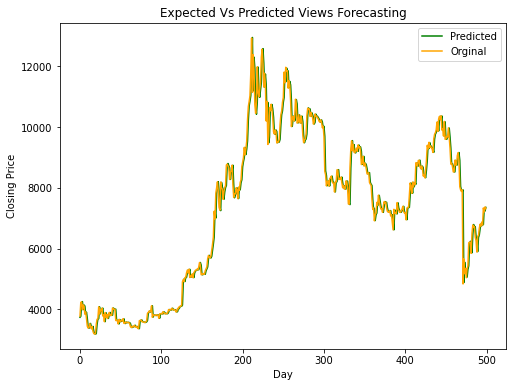

In [27]:
size = int(len(ts_log)-500)
# Divide into train and test
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = sm.tsa.arima.ARIMA(history, order=(2, 1, 0))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = test_arima[t]
    history.append(original_value)
    
    pred_value = dragon.exp(pred_value)
    
    
    original_value = dragon.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plot.figure(figsize=(8, 6))
test_day = [t
           for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plot.plot(test_day, predictions, color= 'green')
plot.plot(test_day, originals, color = 'orange')
plot.title('Expected Vs Predicted Views Forecasting')
plot.xlabel('Day')
plot.ylabel('Closing Price')
plot.legend(labels)
plot.show()

Therefore the original and predicted time series is plotted with mean error of 2.710302%.Therefore we were able to use different transformations and models to predict the closing price of bitcoin.